# SPRINT 1 FINANCER

### En quina mesura els clients amb saldos més baixos estan en més risc d'incompliment de crèdit, i com hem d'ajustar les nostres polítiques de crèdit permitigar aquest risc?


## 1. IMPORTACIÓ BD I CREACIÓ DE DF

In [1]:
from sqlalchemy import create_engine, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
%pip install pymysql
import pymysql
#Dades de connexió

usuario='EquipoB'
contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#URL de la connexió
url_conexion=f"mysql+pymysql://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

#Crear l'engine de SQLAlchemy
try:
    engine=create_engine(url_conexion)
    cnx=engine.connect()
    print("conexió correcta")
except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Obtenir nom de les taules
inspector=inspect(engine)
nombre_tablas=inspector.get_table_names()

#M'asseguro que la vista_finances també tingui el seu DF
if 'vista_finances' not in nombre_tablas:
    nombre_tablas.append('vista_finances')
#Emmagatzemar el DataFrames en una llista
df= {}

for taula in nombre_tablas:
    query=f"select * from {taula}"
    
    try:
        df[taula] = pd.read_sql(query, cnx)
        print(f"Taula '{taula}' carregada correctament.")
    except Exception as e:
        print(f"Error al carregar la taula '{taula}':{e}")

#cnx.close()

Note: you may need to restart the kernel to use updated packages.
conexió correcta
Taula 'BANK_marketing' carregada correctament.
Taula 'vista_finances' carregada correctament.


In [2]:
print(nombre_tablas)

['BANK_marketing', 'vista_finances']


## 2. EDA: ANÀLISI EXPLORATÒRI
Examinem les variables faltante i balance

In [3]:
df_bank = df['BANK_marketing']
df_vistaf = df['vista_finances']
df_vistaf.head()


,id,age,job,marital,education,faltante,balance,housing,loan
0,1,59,admin.,married,secondary,0,2343,1,0
1,3,56,admin.,married,secondary,0,45,0,0
2,4,41,technician,married,secondary,0,1270,1,0
3,5,55,services,married,secondary,0,2476,1,0
4,6,54,admin.,married,tertiary,0,184,0,0


In [4]:
len(df_vistaf)

11162

In [5]:
df_vistaf.describe()

,id,age,faltante,balance,housing,loan
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5582.499910,41.232754,0.015051,1528.538524,0.473123,0.130801
std,3222.336342,11.910672,0.121761,3225.413326,0.499299,0.337198
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000
25%,2792.250000,32.000000,0.000000,122.000000,0.000000,0.000000
50%,5582.500000,39.000000,0.000000,550.000000,0.000000,0.000000
75%,8372.750000,49.000000,0.000000,1708.000000,1.000000,0.000000
max,11163.000000,95.000000,1.000000,81204.000000,1.000000,1.000000


In [6]:
df_vistaf['faltante'].value_counts()

faltante
0    10994
1      168
Name: count, dtype: int64

In [7]:
df_vistaf['balance'].value_counts()

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: count, Length: 3805, dtype: int64

In [8]:
df_vistaf['balance'].isnull().sum()

0

Busquem posibles outliers a balance.

In [9]:
Q1 = df_vistaf['balance'].quantile(0.25)
Q3 = df_vistaf['balance'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df_vistaf['balance'] < (Q1-1.5*IQR)) | (df_vistaf['balance'] > (Q3 + 1.5*IQR))
outliers.sum()



1055

Es gairebé un 10%, son molts, vegem la distribució amb visualitzacions primer i ajustem el factor de multiplicació * IQR després.

### VISUALITZACIONS

#### FALTANTE

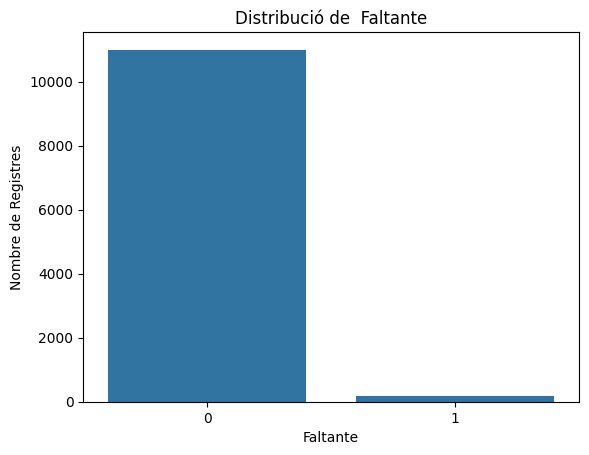

In [10]:
sns.countplot(x='faltante', data= df_vistaf)
plt.title('Distribució de  Faltante')
plt.xlabel('Faltante')
plt.ylabel('Nombre de Registres')
plt.show()

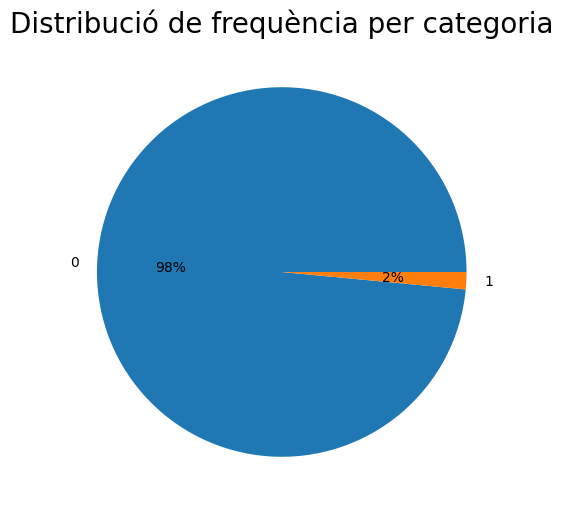

In [11]:
compteig_faltante= df_vistaf['faltante'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(compteig_faltante,labels=compteig_faltante.index, autopct='%1.0f%%')
plt.title("Distribució de frequència per categoria", fontsize=20 )
plt.show()

Podem veure que es una distribució molt asimètrica hi ha només un 2% de clients amb 'faltante' al banc. Es a dir el 98% dels clients no están en situació de morositat amb el banc.

#### BALANCE

<function matplotlib.pyplot.show(close=None, block=None)>

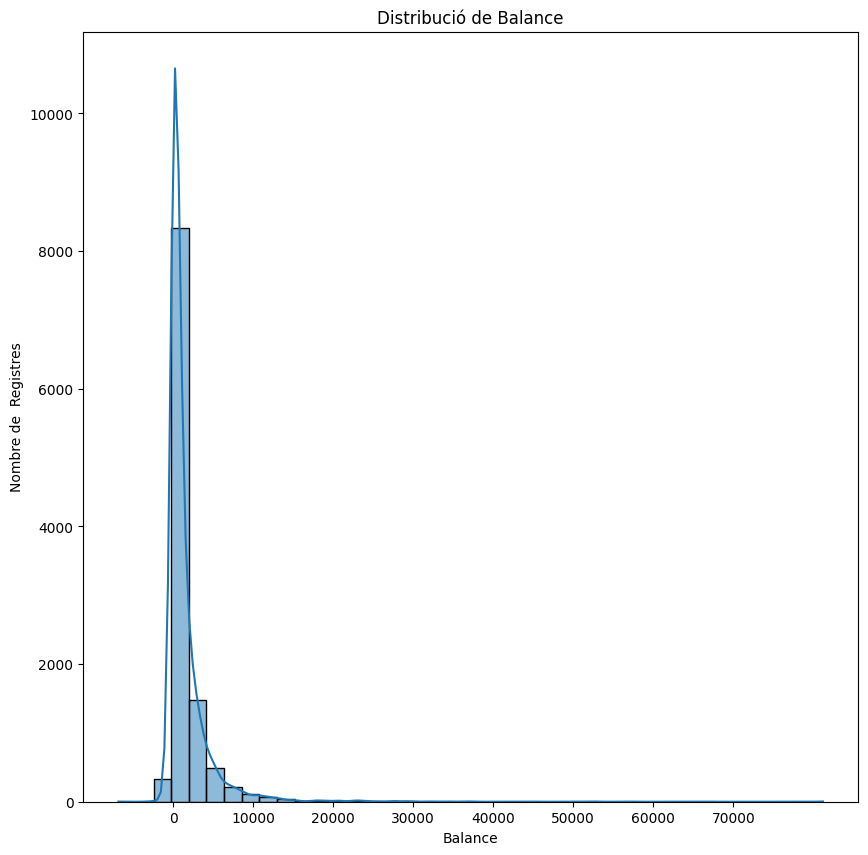

In [15]:
plt.figure(figsize=(10,10))
sns.histplot(df_vistaf['balance'], bins=40, kde=True)
plt.title('Distribució de Balance')
plt.xlabel('Balance')
plt.ylabel('Nombre de  Registres')
plt.xticks(range(0,80000,10000))
plt.show

Podem veure una distribució asimètrica amb cua a la dreta. Hi ha un pic molt destacat entre 0 i el proper bin on hi ha la inmensa majoria de registres. La majoria de clientes tenen balanços entre 0 i 2000,  mentre que molt pocs clients tenen blanços molt alts, de mes 50.000.

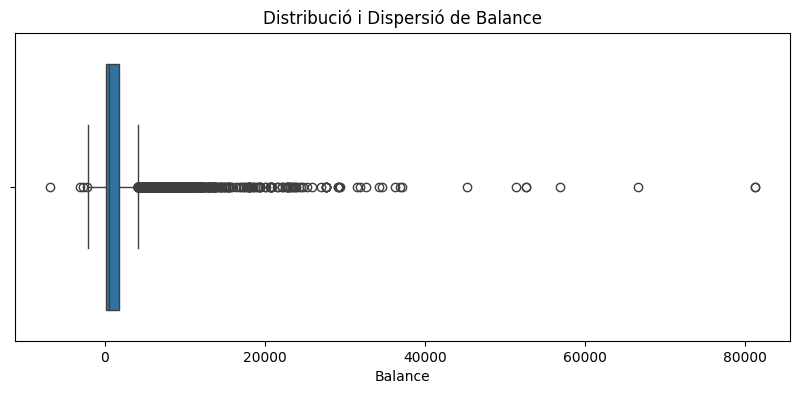

In [21]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_vistaf['balance'])
plt.title('Distribució i Dispersió de Balance')
plt.xlabel('Balance')
plt.show()

Podem veure una caixa entre Q1 i Q3 molt estreta i, per tant una gran concentració de clients amb 'balance' entre 0 i 2000.
Veiem el gran nombre d'outliers que apareixen , sobretot per la dreta, confirmant el que mostrava el primer anàlisis numéric d'outliers.
Semblaria que la immensa majoria de clients utilitzen el banc com banc de gestió de nòmines i pagaments corrents i una petita part l'utlitza també coma  banc d'inversió i d'estalvi.
També es pot valorar la possibilitat que, aquesta distribució de 'balance', representi la distribució de la riquesa en la societat d'aquell país i que, per tant, poguem inferir que es tracta d'un país on la inmensa majoria de la gent no te estalvis, mentre que un minoria sí que en té.